In [1]:
import numpy as np

In [2]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle 
import numpy as np
import functools

ρcrit0 = 2.77533742639e+11 #h^2 Msol / Mpc^3

def M_to_R(M, box, a):
    """
    Converts mass of top-hat filter to radius of top-hat filter
    
    Parameters:
        - M (float): Mass of the top hat filter in units Msolor/h
        - box (string): Which Aemulus nu box we're considering 
        - a (float): Redshift 

    Returns:
        - R (float): Corresponding radius of top hat filter Mpc/h
    """

    return (M / (4/3 * math.pi * rhom_a(box, a))) ** (1/3) # h^-1 Mpc  

def R_to_M(R,box, a):
    """
    Converts radius of top-hat filter to mass of top-hat filter
    
    Parameters:
        - R (float): Radius of the top hat filter in units Mpc/h
        - box (string): Which Aemulus nu box we're considering 
        - a (float): Redshift 

    Returns:
        - M (float): Corresponding mass of top hat filter Msolar/h 
    """
    return R ** 3 * 4/3 * math.pi * rhom_a(box, a)

def scaleToRedshift(a):
    return 1/a-1

def redshiftToScale(z):
    return 1/(1+z)

@functools.cache
def sigma2(pk, R):
    """
    Adapated from https://github.com/komatsu5147/MatterPower.jl
    Computes variance of mass fluctuations with top hat filter of radius R
    For this function let k be the comoving wave number with units h/Mpc

    Parameters:
        - pk (funtion): P(k), the matter power spectrum which has units Mpc^3 / h^3
        - R (float): The smoothing scale in units Mpc/h
    Returns:
        - sigma2 (float): The variance of mass fluctuations
    """

    def dσ2dk(k):
        x = k * R
        W = (3 / x) * (np.sin(x) / x**2 - np.cos(x) / x)
        dσ2dk = W**2 * pk(k) * k**2 / 2 / np.pi**2
        return dσ2dk
    res, err = quad(dσ2dk, 0, np.inf)
    σ2 = res
    return σ2

def rhom_a(box, a):
    '''comoving'''
    ombh2 = cosmo['ombh2']
    omch2 = cosmo['omch2']
    H0 = cosmo['H0'] #[km s^-1 Mpc-1]
    h = H0/100 

    Ωm = ombh2/h**2 + omch2/h**2
    
    ΩDE = 1 - Ωm
    wDE = cosmo['w0'] #'wa' is zero for us
    return Ωm*ρcrit0#*(Ωm*a**(-3) + ΩDE*a**(-3*(1+wDE))) * a**3 # h^2 Msol/Mpc^3
    
def dsigma2dR(pk, R):
    """
    Adapated from https://github.com/komatsu5147/MatterPower.jl
    Computes deriative of variance of mass fluctuations wrt top hat filter of radius R
    For this function let k be the comoving wave number with units h/Mpc
    
    Parameters:
        - pk (funtion): P(k), the matter power spectrum which has units Mpc^3 / h^3
        - R (float): The smoothing scale in units Mpc/h
    Returns:
        - dsigma2dR (float): The derivative of the variance of mass fluctuations wrt R
    """

    def dσ2dRdk(k):
        x = k * R
        W = (3 / x) * (np.sin(x) / x**2 - np.cos(x) / x)
        dWdx = (-3 / x) * ((3 / x**2 - 1) * np.sin(x) / x - 3 * np.cos(x) / x**2)
        dσ2dRdk = 2 * W * dWdx * pk(k) * k**3 / 2 / np.pi**2
        return dσ2dRdk
    res, err = quad(dσ2dRdk, 0, 20 / R)
    return res

def dRdM(M, box, a):
    return 1/(6**(2/3)*np.pi**(1/3)*M**(2/3)*rhom_a(box, a)**(1/3))

In [3]:
#https://github.com/tmcclintock/Aemulus_data/blob/e4a2b28571cfba99d8ceda8913fb6e2fd42ab6f3/aemulus_data/building_box_cosmologies.txt
line1 = "# ombh2 omch2 w0 ns ln10As H0 Neff sigma8"
line2 = "2.268324999999999855e-02 1.140598000000000029e-01 -8.165972000000000230e-01 9.755890000000000395e-01 3.092918000000000056e+00 6.336569000000000074e+01 2.918750000000000178e+00 7.730715000000000225e-01"

In [4]:
columns = [col for col in line1.split()[1:]]
cosmo  = dict(zip(columns, np.array(line2.split(), dtype=np.float64)))
print(cosmo)
box = 'Box000'

{'ombh2': 0.02268325, 'omch2': 0.1140598, 'w0': -0.8165972, 'ns': 0.975589, 'ln10As': 3.092918, 'H0': 63.36569, 'Neff': 2.91875, 'sigma8': 0.7730715}


In [5]:
Pk_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alpha_check/'+box+'_Pk.pkl'
Pk_f = open(Pk_fname, 'rb')
Pkz = pickle.load(Pk_f)
Pk_f.close()

In [6]:
curr_run_fname = "/oak/stanford/orgs/kipac/aemulus/aemulus_alpha/" + box + "/";


NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alpha_check/'+curr_run_fname.split('/')[-2]+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


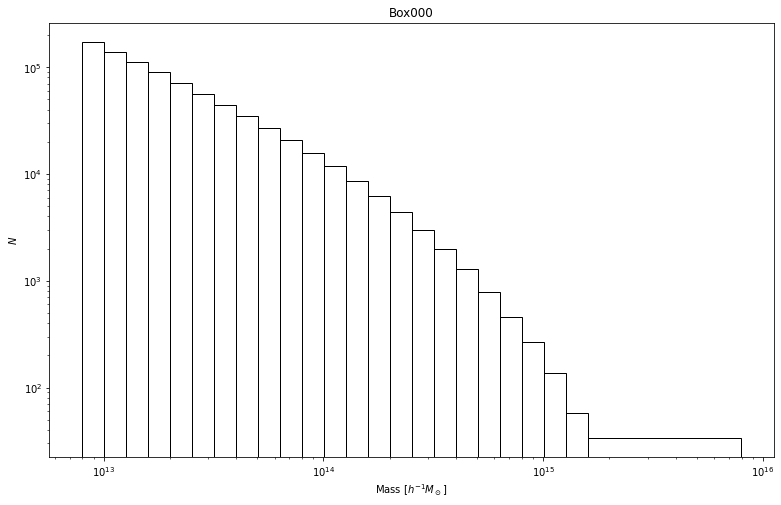

In [7]:
aC = 1.00
N = NvMs[aC]['N']
ep = NvMs[aC]['edge_pairs']
bin_edge = [epc[0] for epc in ep]
bin_edge += [ep[-1][1]]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,8))

ax.bar(x=bin_edge[:-1], height=N, width=np.diff(bin_edge), align='edge', fill=False)#, label=r'$a=%.2f$'%(a))

ax.set_title(curr_run_fname.split('/')[-2])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Mass $[h^{-1}M_\odot]$')
ax.set_ylabel(r'$N$')
ax.legend(frameon=False)


In [8]:
#deal with floating point errors
a_to_z = dict(zip(NvMs.keys(), Pkz.keys()))
z_to_a = dict(zip(Pkz.keys(), NvMs.keys()))

In [9]:
print(cosmo)

{'ombh2': 0.02268325, 'omch2': 0.1140598, 'w0': -0.8165972, 'ns': 0.975589, 'ln10As': 3.092918, 'H0': 63.36569, 'Neff': 2.91875, 'sigma8': 0.7730715}


In [10]:
# LOOKING_AT = [a_RUN]
from tqdm import trange, tqdm

N_data = {}
M_data = {}
aux_data = {}
from scipy.interpolate import interp1d

dlnσinvdMs = {}

vol = -1 #comoving Mpc^3/h^3
Mpart = -1

for z in tqdm(Pkz.keys()):
    a = z_to_a[z]
#     if(a not in LOOKING_AT):
#         continue
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]
    
    M_numerics = np.logspace(np.log10(100*Mpart), 17, 100) #h^-1 Msolar
    
    
    R = [M_to_R(m, box, a) for m in M_numerics] #h^-1 Mpc
    
    M_log10 = np.log10(M_numerics)
    sigma2s = [sigma2(Pk, r) for r in R]
    sigma = np.sqrt(sigma2s)
    lnsigmainv = -np.log(sigma)
    dlnsinvdlogM = np.gradient(lnsigmainv, M_log10)
    
    f_dlnsinvdlogM_log = interp1d(M_log10, dlnsinvdlogM,kind='cubic')
    f_dlnsinvdM = lambda M: f_dlnsinvdlogM_log(np.log10(M)) / (M * np.log(10)) 
    
    dlnσinvdMs[a] = f_dlnsinvdM    

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_28484/2583163611.py:64: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


In [11]:
#https://github.com/tmcclintock/aemulus_simulation_testing/blob/5edd3b7c30d87f0f715ec974e666ecedd5d48059/bfs/bf_dfg_box0.txt
bf_params = {
    'd0':2.4,
    'd1':2.181047599569275963e+00,
    'e0':8.533560474520303085e-01,
    'e1':4.482167434789784966e-01,
    'f0':2.117323359155323381e-01,
    'f1':0.12,
    'g0':1.308324286279444193e+00,
    'g1':3.444272270175428030e-01
}

#https://github.com/tmcclintock/aemulus_simulation_testing/blob/5edd3b7c30d87f0f715ec974e666ecedd5d48059/bf_defg_box0.txt
bf_params = {
'd0': 2.174821518616466776e+00,
'd1': 2.866865716329323743e-01,
'e0': 9.956259364301934811e-01,
'e1': 2.616888864012535953e-01,
'f0': 4.488975264972323020e-01,
'f1': 1.129116545674591771e-01,
'g0': 1.308036208759035368e+00,
'g1':3.008737013596629595e-01,
}

In [12]:
from scipy.special import gamma
from scipy.optimize import curve_fit

def p(a, p0, p1):
    oup = (p0)+(a-0.5)*(p1)
    return oup

def B(a, M, σM, d, e, f, g):
    oup = e**(d)*g**(-d/2)*gamma(d/2)
    oup += g**(-f/2)*gamma(f/2)
    oup = 2/oup
    return oup
    
    
def f_G(a, M, σM, d, e, f, g):
    oup = B(a, M, σM, d, e, f, g)
    oup *= ((σM/e)**(-d)+σM**(-f))
    oup *= np.exp(-g/σM**2)
    return oup

def tinker(a, M, 
           d0, d1,
          e0, e1,
          f0, f1,
          g0,g1):
    d = p(a, d0, d1)
    e = p(a, e0, e1)
    f = p(a, f0, f1)
    g = p(a, g0, g1)
    
    R = M_to_R(M, box, a) #Mpc/h
    σM = np.sqrt(sigma2(Pkz[a_to_z[a]], R))  
    oup = f_G(a, M, σM, d, e, f, g)
    oup *= rhom_a(box, a)/M
    oup *= dlnσinvdMs[a](M)
    return oup

In [13]:
cosmo

{'ombh2': 0.02268325,
 'omch2': 0.1140598,
 'w0': -0.8165972,
 'ns': 0.975589,
 'ln10As': 3.092918,
 'H0': 63.36569,
 'Neff': 2.91875,
 'sigma8': 0.7730715}

In [14]:

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alpha_check/'+curr_run_fname.split('/')[-2]+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()



jack_covs = {a:jackknife[a][1] for a in NvMs}

# Compute the weighted covariance matrix incorporating jackknife and poisson
weighted_cov = {a: jack_covs[a] for a in jack_covs}

# Inverse of the weighted covariance matrix
inv_weighted_cov = {a:np.linalg.inv(weighted_cov[a])  for a in weighted_cov}  
scale_cov = {a:np.log(np.linalg.det(weighted_cov[a])) for a in weighted_cov}

In [15]:
import pyccl 
import MiraTitanHMFemulator

Ommh2 = cosmo['ombh2'] + cosmo['omch2']
HMFemu = MiraTitanHMFemulator.Emulator()
Omnuh2 = pyccl.neutrinos.Omeganuh2(1, m_nu=[0,0,0], T_CMB=2.7255)
print(Omnuh2)
fiducial_cosmo = {'Ommh2': Ommh2,
                  'Ombh2': cosmo['ombh2'],
                  'Omnuh2': Omnuh2,
                  'n_s': cosmo['ns'],
                  'h': cosmo['H0']/100,
                  'w_0': cosmo['w0'],
                  'w_a': 0,
                  'sigma_8': cosmo['sigma8'],
                 }



5.054503751002418e-05


In [16]:
cosmo

{'ombh2': 0.02268325,
 'omch2': 0.1140598,
 'w0': -0.8165972,
 'ns': 0.975589,
 'ln10As': 3.092918,
 'H0': 63.36569,
 'Neff': 2.91875,
 'sigma8': 0.7730715}

In [17]:
import pyccl as ccl
# cosmo = cosmo_params[box]
h = cosmo['H0']/100
cosmo_dict = {
    'h': h,
    'Omega_b': cosmo['ombh2'] / h**2,
    'Omega_c': cosmo['omch2'] / h**2,
    'w0': cosmo['w0'],
    'wa': 0.0,
    'A_s': np.exp(cosmo['ln10As'])/(10**10),
    'm_nu': 0,
    'T_CMB': 2.7255, 
    'n_s': cosmo['ns'],
}

ccl_cosmo = ccl.Cosmology(**cosmo_dict)

[1.01619976 1.01312997 1.0097882  1.00612865 1.0021835  0.99778541
 0.99315372 0.98814708 0.98288051 0.97728693 0.97157238 0.96573224
 0.95989292 0.95431163 0.94909004 0.94449208 0.94084996 0.93855828
 0.93816506 0.94005752 0.94529917 0.95463557 0.96932348 1.00742188]


/tmp/ipykernel_28484/2393670834.py:109: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


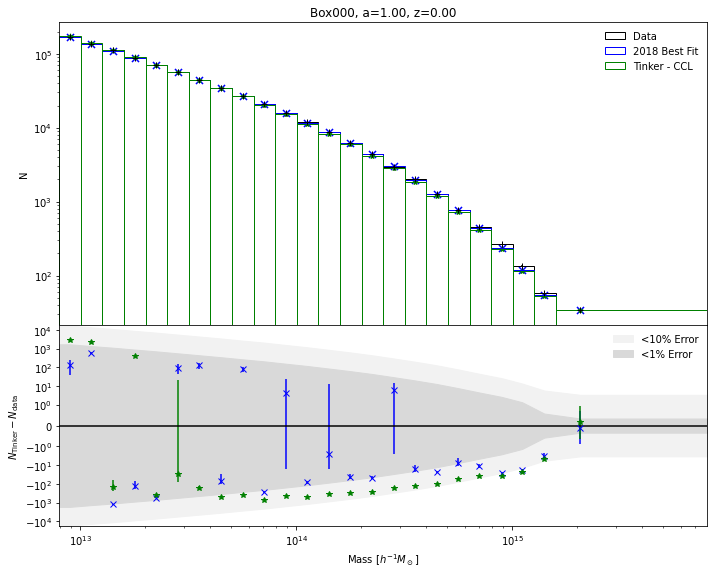

[1.01440775 1.01116358 1.00757529 1.00359243 0.99924192 0.99435163
 0.98913421 0.98344139 0.97737979 0.9708732  0.96411549 0.95708755
 0.94989873 0.94278256 0.93581322 0.92921905 0.92328663 0.918352
 0.91488383 0.91317512 0.91414604 0.91836597 0.93532079]


/tmp/ipykernel_28484/2393670834.py:109: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


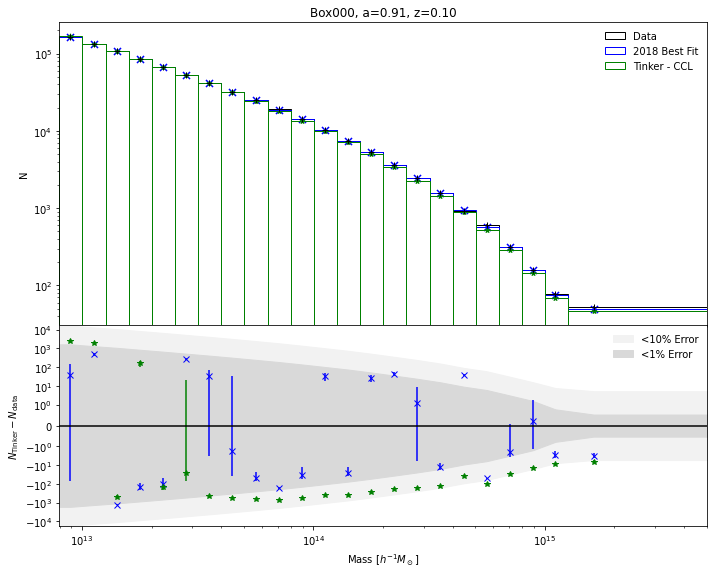

[1.00890231 1.00515231 1.00096227 0.99627828 0.99112298 0.98532211
 0.97908244 0.97225138 0.96492889 0.95703273 0.94874603 0.94003749
 0.93100178 0.9218492  0.91262818 0.90353214 0.89480223 0.88671611
 0.87967731 0.87384111 0.87002255 0.87029044]


/tmp/ipykernel_28484/2393670834.py:109: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


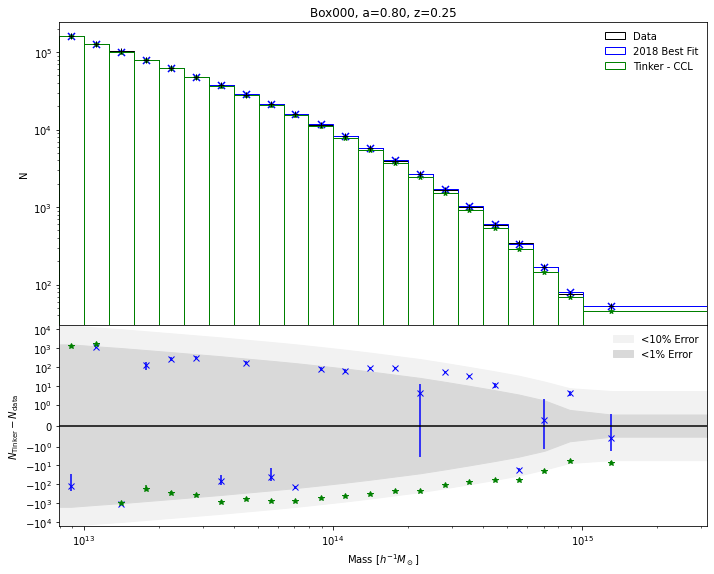

[1.00085821 0.99644516 0.99151678 0.9860194  0.9799753  0.97321304
 0.9659378  0.95799843 0.94949399 0.94034315 0.93072547 0.92060603
 0.91007458 0.89932938 0.88840684 0.87748171 0.8667699  0.85651638
 0.84707846 0.83855596 0.82971973]


/tmp/ipykernel_28484/2393670834.py:109: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


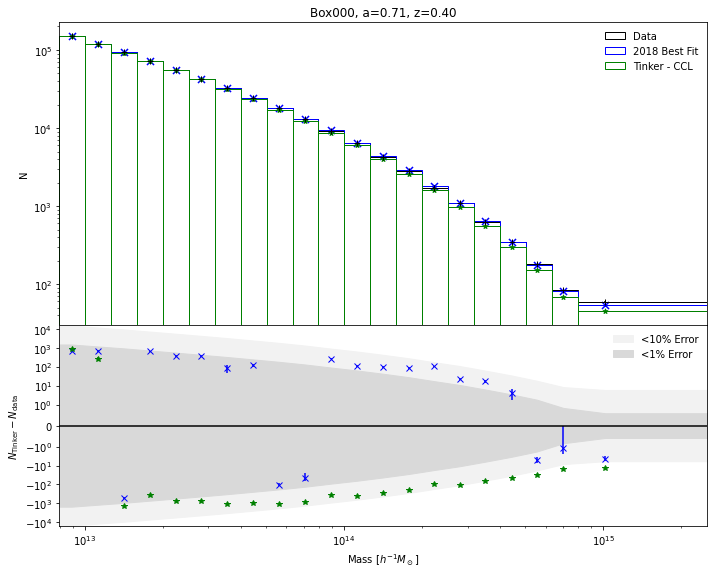

[0.99080835 0.98564269 0.97990575 0.97354645 0.96658916 0.9588708
 0.95059485 0.9416161  0.9320361  0.92177849 0.9110233  0.89973672
 0.88800904 0.87603267 0.86383956 0.85159468 0.83949979 0.82778169
 0.81677001 0.80653092 0.79510936]


/tmp/ipykernel_28484/2393670834.py:109: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


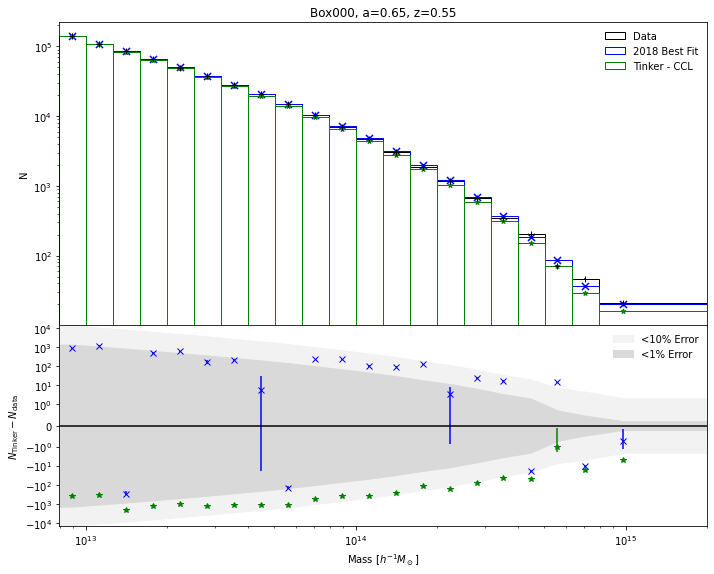

[0.97914208 0.9731875  0.96662376 0.95940434 0.95155751 0.94292901
 0.93372418 0.92380507 0.91327756 0.90207248 0.89037245 0.87815184
 0.86549035 0.85259251 0.83948474 0.8263273  0.81331421 0.800663
 0.78868706 0.77389696]


/tmp/ipykernel_28484/2393670834.py:109: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


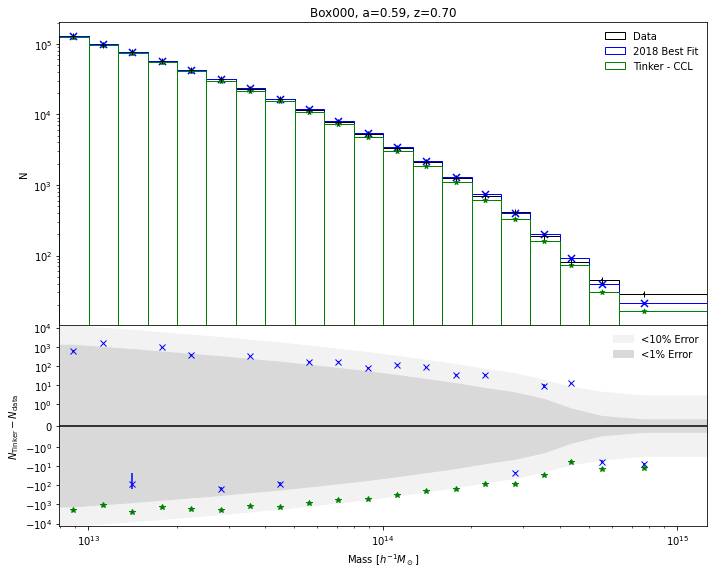

[0.96609807 0.95934717 0.95196449 0.94390908 0.93521391 0.92573474
 0.91567928 0.90491766 0.89356077 0.88154747 0.86906374 0.85608895
 0.84270526 0.82911857 0.81535609 0.80157538 0.78796574 0.77474063
 0.75791769]


/tmp/ipykernel_28484/2393670834.py:109: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


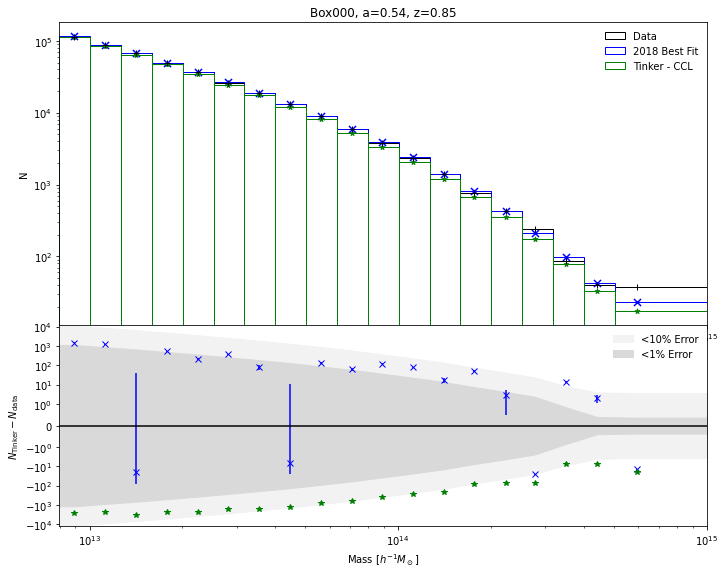

[0.95188294 0.94435021 0.9361758  0.9273253  0.91783694 0.90757288
 0.89674807 0.88523916 0.87316189 0.86046316 0.8473323  0.83375348
 0.81981142 0.80571395 0.79148978 0.77729431 0.76331325 0.74501564]


/tmp/ipykernel_28484/2393670834.py:109: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


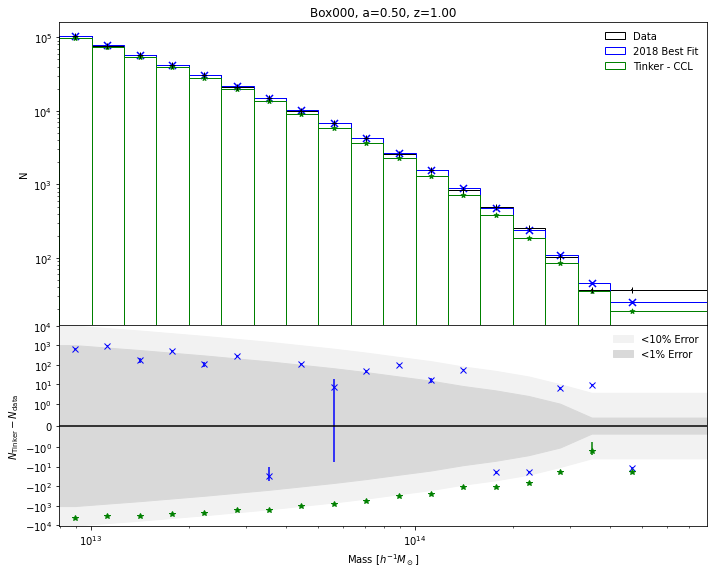

In [19]:
from scipy.interpolate import interp1d
i=0
#TODO HALO TOOLS M200c to M200b
for a in reversed(N_data.keys()):
    z = a_to_z[a]
    if(z>=2):
        break
    fig1 = plt.figure(figsize =(12, 7))

    axs=[fig1.add_axes((0.2,0.4,.75,.6)), fig1.add_axes((0.2,0.0,.75,.4))]
    plt.subplots_adjust(wspace=0, hspace=0)
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = M_data[a]
    N = N_data[a]
    edge_pairs = c_data['edge_pairs']
    
    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]


    vol = vol
    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])
    dndM = (np.array(N)/vol)/dM
    tinker_eval_MCMC = [tinker(a, M_c,**bf_params) for M_c in Ms]
    
    yerr = np.sqrt(np.diagonal(weighted_cov[a]))
    
    #evaluating 2018 Best fit
    tinker_eval_MCMC = [tinker(a, M_c,**bf_params,)*vol for M_c in M_numerics]
    f_dndM_MCMC_LOG = interp1d(np.log10(M_numerics), tinker_eval_MCMC, kind='cubic', bounds_error=False, fill_value=0.)
    f_dndM_MCMC = lambda x:f_dndM_MCMC_LOG(np.log10(x))
    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1])[0] for edge in edge_pairs])

    #evaluating Mira-Titan
    M_numerics_MT =np.logspace(13, 16, 100)
    MT_eval = np.array(HMFemu.predict(fiducial_cosmo, z, M_numerics_MT))[0]/M_numerics_MT
    f_dndM_MT_LOG = interp1d(np.log10(M_numerics_MT), MT_eval, 
                           kind='cubic', bounds_error=False, fill_value=0.)
    #NOTE Mira-Titan gives as function of M200c, not M200b like us
    f_dndM_MT_M200b = lambda M200b:f_dndM_MT_LOG(np.log10(M200b/0.3))
    MT_eval = np.array([vol*quad(f_dndM_MT_M200b, 
                                 (edge[0]),  
                                 (edge[1]))[0] for edge in edge_pairs])

    
    #from CCL
    hmf = ccl.halos.MassFuncTinker08(ccl_cosmo)
    tinker_eval_CCL = hmf.get_mass_function(ccl_cosmo, M_numerics, a)*vol/h**3 # dn/dlog10 
    f_dndM_CCL_LOG = interp1d(np.log10(M_numerics), tinker_eval_CCL, kind='cubic', bounds_error=False, fill_value=0.)
    tinker_eval_CCL = np.array([quad(f_dndM_CCL_LOG, np.log10(edge[0]/h),  np.log10(edge[1]/h))[0] for edge in edge_pairs])
    print(tinker_eval_CCL/ tinker_eval_MCMC)
    
    color = plt.colormaps["rainbow"]((i+1)/len(Pkz.keys()))[:-1]

    

    axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')
    axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')
#     axs[0].scatter(Ms, MT_eval, s=25 , marker='o', c='red')
    axs[0].scatter(Ms, tinker_eval_CCL, s=25 , marker='*', c='green')

    edges = np.array(edges)
    tmp = 0# edges[:-1]*10**(0.01)-edges[:-1]
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
               align='edge', fill=False, ec='black', label='Data')
    axs[0].bar(x=edges[:-1]-tmp, height=tinker_eval_MCMC, width=np.diff(edges), align='edge', fill=False, ec='blue', label='2018 Best Fit')
#     axs[0].bar(x=edges[:-1]-tmp, height=MT_eval, width=np.diff(edges), align='edge', fill=False, 
#                ec='red', label='Mira-Titan')
    axs[0].bar(x=edges[:-1]-tmp, height=tinker_eval_CCL, width=np.diff(edges), align='edge', fill=False, 
               ec='green', label='Tinker - CCL')

    axs[1].errorbar(Ms, (tinker_eval_MCMC-N), yerr, fmt='x', color='blue')
#     axs[1].errorbar(Ms, (MT_eval-N), yerr, fmt='o', color='red')
    axs[1].errorbar(Ms, (tinker_eval_CCL-N), yerr, fmt='*', color='green')

    y1 = 0.1*np.array(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.array(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

    y1 = 0.01*np.array(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.array(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)
    
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')
    

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    axs[1].set_yscale('symlog', linthresh=1)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'${N_{\rm Tinker}-N_{\rm data}} $')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, a_to_z[a]))
    i+=1
    
    axs[0].set_xlim((200*Mpart, np.max(edges)))
    axs[1].set_xlim((200*Mpart, np.max(edges)))

    plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/alpha_check_%s_ML+MCMCFits_a%.2f.pdf'%(box, a), bbox_inches='tight')
    plt.show()
